Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


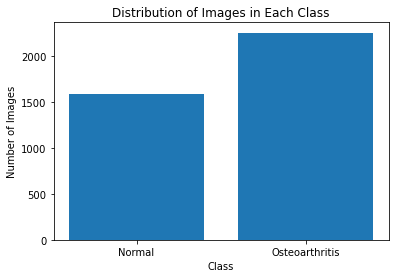

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-24 13:07:29.512824: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 13:07:29.514158: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 13:07:29.575425: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 13:07:29.808886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 13:07:30.403436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


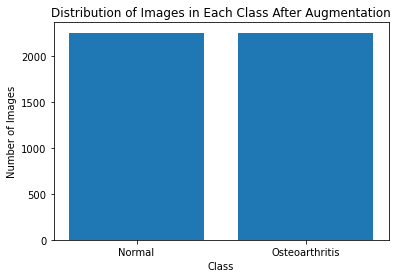

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 2257)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 2257)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 2257 + [1] * 2257  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 2527
X_test size: 1355
X_validation size: 632


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

# CNN+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
X_train = np.array(X_train) / 255.0  # Scale pixel values to [0, 1]
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 278ms/step - accuracy: 0.5119 - loss: 0.8499 - val_accuracy: 0.5459 - val_loss: 0.6826
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.5405 - loss: 0.6810 - val_accuracy: 0.5744 - val_loss: 0.6767
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.5773 - loss: 0.6738 - val_accuracy: 0.5791 - val_loss: 0.6721
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step - accuracy: 0.5608 - loss: 0.6734 - val_accuracy: 0.5696 - val_loss: 0.6733
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.5890 - loss: 0.6546 - val_accuracy: 0.5775 - val_loss: 0.6644
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.5999 - loss: 0.6399 - val_accuracy: 0.5601 - val_loss: 0.6818
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.6310 - loss: 0.6233 - val_accuracy: 0.5870 - val_loss: 0.6742
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.6689 - loss: 0.5928 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


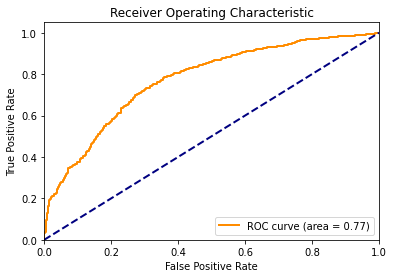

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6905 - loss: 0.6143
Validation Loss: 0.6187207102775574
Validation Accuracy: 0.6787974834442139
Test Loss: 0.6040537813881152
Inference Time (seconds): 3.407073736190796
Test Accuracy: 0.7077490774907749
Confusion Matrix:
 [[470 236]
 [160 489]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.70       706
           1       0.67      0.75      0.71       649

    accuracy                           0.71      1355
   macro avg       0.71      0.71      0.71      1355
weighted avg       0.71      0.71      0.71      1355

ROC AUC Score: 0.7722405793179309
Metrics saved successfully


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.7501 - loss: 0.4779 - val_accuracy: 0.6820 - val_loss: 0.6312
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.7814 - loss: 0.4328 - val_accuracy: 0.7041 - val_loss: 0.6216
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8090 - loss: 0.3970 - val_accuracy: 0.6978 - val_loss: 0.7065
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.8208 - loss: 0.3726 - val_accuracy: 0.7263 - val_loss: 0.6393
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8569 - loss: 0.3247 - val_accuracy: 0.7547 - val_loss: 0.6016
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8701 - loss: 0.3093 - val_accuracy: 0.7168 - val_loss: 0.6453
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8952 - loss: 0.2481 - val_accuracy: 0.7500 - val_loss: 0.7002
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9056 - loss: 0.2178 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


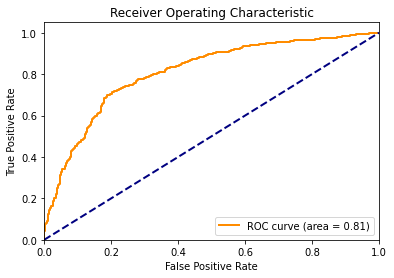

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7521 - loss: 0.6454
Validation Loss: 0.60160893201828
Validation Accuracy: 0.7547468543052673
Test Loss: 0.6382189840473629
Inference Time (seconds): 3.347459077835083
Test Accuracy: 0.7542435424354244
Confusion Matrix:
 [[548 158]
 [175 474]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       706
           1       0.75      0.73      0.74       649

    accuracy                           0.75      1355
   macro avg       0.75      0.75      0.75      1355
weighted avg       0.75      0.75      0.75      1355

ROC AUC Score: 0.8086771105688857
Metrics saved successfully


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.8953 - loss: 0.2515 - val_accuracy: 0.7579 - val_loss: 0.6150
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.9066 - loss: 0.2283 - val_accuracy: 0.7310 - val_loss: 0.6764
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9190 - loss: 0.1962 - val_accuracy: 0.7326 - val_loss: 0.7436
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9204 - loss: 0.1966 - val_accuracy: 0.7468 - val_loss: 0.6506
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9536 - loss: 0.1285 - val_accuracy: 0.7563 - val_loss: 0.7615
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9467 - loss: 0.1381 - val_accuracy: 0.7468 - val_loss: 0.8025
Training Time: 138.5190875530243 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


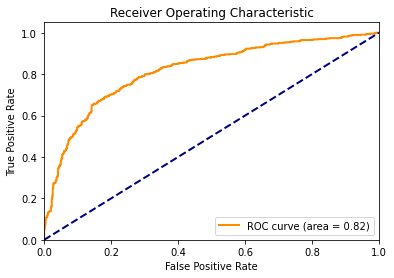

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7472 - loss: 0.6767
Validation Loss: 0.615021824836731
Validation Accuracy: 0.7579113841056824
Test Loss: 0.7094463566127667
Inference Time (seconds): 3.3484575748443604
Test Accuracy: 0.7490774907749077
Confusion Matrix:
 [[512 194]
 [146 503]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75       706
           1       0.72      0.78      0.75       649

    accuracy                           0.75      1355
   macro avg       0.75      0.75      0.75      1355
weighted avg       0.75      0.75      0.75      1355

ROC AUC Score: 0.8171560518033847
Metrics saved successfully


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9062 - loss: 0.2209 - val_accuracy: 0.7358 - val_loss: 0.7643
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9120 - loss: 0.2139 - val_accuracy: 0.7579 - val_loss: 0.6798
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.9355 - loss: 0.1781 - val_accuracy: 0.7437 - val_loss: 0.6954
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9330 - loss: 0.1671 - val_accuracy: 0.7453 - val_loss: 0.8892
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9566 - loss: 0.1136 - val_accuracy: 0.7516 - val_loss: 0.7720
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.9640 - loss: 0.1054 - val_accuracy: 0.7500 - val_loss: 0.8994
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9609 - loss: 0.1054 - val_accuracy: 0.7642 - val_loss: 0.8429
Training Time: 160.93784642219543 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


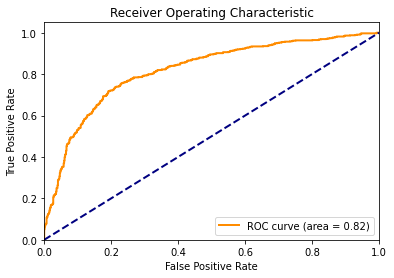

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7481 - loss: 0.7230
Validation Loss: 0.679781436920166
Validation Accuracy: 0.7579113841056824
Test Loss: 0.7719878365241838
Inference Time (seconds): 3.333979368209839
Test Accuracy: 0.7616236162361624
Confusion Matrix:
 [[540 166]
 [157 492]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77       706
           1       0.75      0.76      0.75       649

    accuracy                           0.76      1355
   macro avg       0.76      0.76      0.76      1355
weighted avg       0.76      0.76      0.76      1355

ROC AUC Score: 0.81800067220435
Metrics saved successfully


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# CNN+Dropout+Dense

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define CNN architecture for RGB images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Change input shape to (224, 224, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - accuracy: 0.5027 - loss: 0.8925 - val_accuracy: 0.5079 - val_loss: 0.6869
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.5293 - loss: 0.6862 - val_accuracy: 0.5554 - val_loss: 0.6870
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.5581 - loss: 0.6809 - val_accuracy: 0.5491 - val_loss: 0.6889
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.5547 - loss: 0.6814 - val_accuracy: 0.5570 - val_loss: 0.6750
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.5736 - loss: 0.6663 - val_accuracy: 0.5522 - val_loss: 0.6748
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.5822 - loss: 0.6633 - val_accuracy: 0.5870 - val_loss: 0.6673
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.5897 - loss: 0.6520 - val_accuracy: 0.5981 - val_loss: 0.6569
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.6191 - loss: 0.6353 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


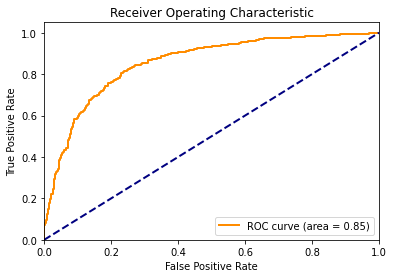

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7414 - loss: 0.5339
Validation Loss: 0.5621771812438965
Validation Accuracy: 0.7389240264892578
Test Loss: 0.5091318662821427
Inference Time (seconds): 3.842921733856201
Test Accuracy: 0.7815498154981549
Confusion Matrix:
 [[547 159]
 [137 512]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       706
           1       0.76      0.79      0.78       649

    accuracy                           0.78      1355
   macro avg       0.78      0.78      0.78      1355
weighted avg       0.78      0.78      0.78      1355

ROC AUC Score: 0.853887218077932
Metrics saved successfully


In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8747 - loss: 0.2890 - val_accuracy: 0.7468 - val_loss: 0.6335
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.8587 - loss: 0.3079 - val_accuracy: 0.7706 - val_loss: 0.6380
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.8922 - loss: 0.2511 - val_accuracy: 0.7785 - val_loss: 0.6397
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - accuracy: 0.9198 - loss: 0.1958 - val_accuracy: 0.7785 - val_loss: 0.6308
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9225 - loss: 0.1889 - val_accuracy: 0.7911 - val_loss: 0.6828
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9239 - loss: 0.1752 - val_accuracy: 0.7500 - val_loss: 0.7850
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9244 - loss: 0.1962 - val_accuracy: 0.7816 - val_loss: 0.6755
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9376 - loss: 0.1485 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


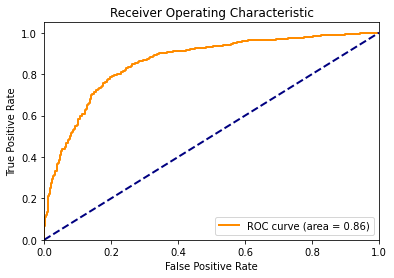

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7619 - loss: 0.6277
Validation Loss: 0.6307774186134338
Validation Accuracy: 0.7784810066223145
Test Loss: 0.5652380384012459
Inference Time (seconds): 3.547985553741455
Test Accuracy: 0.7867158671586716
Confusion Matrix:
 [[536 170]
 [119 530]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       706
           1       0.76      0.82      0.79       649

    accuracy                           0.79      1355
   macro avg       0.79      0.79      0.79      1355
weighted avg       0.79      0.79      0.79      1355

ROC AUC Score: 0.8585118967075083
Metrics saved successfully


In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [28]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9259 - loss: 0.2034 - val_accuracy: 0.7690 - val_loss: 0.6753
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.9364 - loss: 0.1778 - val_accuracy: 0.7832 - val_loss: 0.6655
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9420 - loss: 0.1450 - val_accuracy: 0.7975 - val_loss: 0.7553
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.9551 - loss: 0.1384 - val_accuracy: 0.7864 - val_loss: 0.6734
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9385 - loss: 0.1474 - val_accuracy: 0.7801 - val_loss: 0.8338
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - accuracy: 0.9435 - loss: 0.1366 - val_accuracy: 0.7880 - val_loss: 0.7025
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.9643 - loss: 0.0980 - val_accuracy: 0.7706 - val_loss: 0.7385
Training Time: 251.9116015434265 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


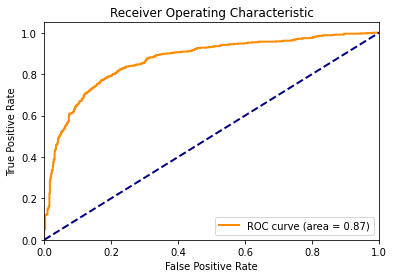

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7815 - loss: 0.6608
Validation Loss: 0.6654702425003052
Validation Accuracy: 0.7832278609275818
Test Loss: 0.5845225626343702
Inference Time (seconds): 3.5556700229644775
Test Accuracy: 0.7948339483394834
Confusion Matrix:
 [[556 150]
 [128 521]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       706
           1       0.78      0.80      0.79       649

    accuracy                           0.79      1355
   macro avg       0.79      0.80      0.79      1355
weighted avg       0.80      0.79      0.79      1355

ROC AUC Score: 0.8677536152808636
Metrics saved successfully


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - accuracy: 0.9387 - loss: 0.1462 - val_accuracy: 0.7975 - val_loss: 0.6747
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.9261 - loss: 0.1689 - val_accuracy: 0.7943 - val_loss: 0.7017
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.9551 - loss: 0.1342 - val_accuracy: 0.7911 - val_loss: 0.7411
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9498 - loss: 0.1232 - val_accuracy: 0.7848 - val_loss: 0.7026
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.9495 - loss: 0.1158 - val_accuracy: 0.7816 - val_loss: 0.7962
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9768 - loss: 0.0820 - val_accuracy: 0.7832 - val_loss: 0.7853
Training Time: 215.85490441322327 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


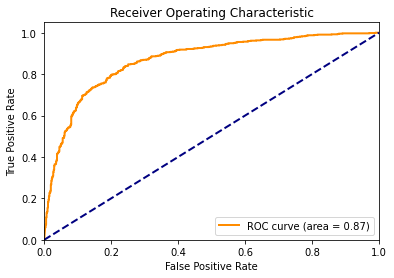

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7894 - loss: 0.6499
Validation Loss: 0.6746767163276672
Validation Accuracy: 0.797468364238739
Test Loss: 0.6097140398243798
Inference Time (seconds): 3.574078321456909
Test Accuracy: 0.7940959409594096
Confusion Matrix:
 [[555 151]
 [128 521]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       706
           1       0.78      0.80      0.79       649

    accuracy                           0.79      1355
   macro avg       0.79      0.79      0.79      1355
weighted avg       0.79      0.79      0.79      1355

ROC AUC Score: 0.8681988415387368
Metrics saved successfully


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GlobbalAveragePooling+Dense

In [32]:
from tensorflow.keras.layers import GlobalAveragePooling2D
#Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.5236 - loss: 0.6940 - val_accuracy: 0.5016 - val_loss: 0.6927
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.5026 - loss: 0.6938 - val_accuracy: 0.4984 - val_loss: 0.6922
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.5099 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6890
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.5187 - loss: 0.6911 - val_accuracy: 0.5617 - val_loss: 0.6879
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.5362 - loss: 0.6921 - val_accuracy: 0.5491 - val_loss: 0.6874
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.5289 - loss: 0.6907 - val_accuracy: 0.5396 - val_loss: 0.6861
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.5450 - loss: 0.6894 - val_accuracy: 0.4984 - val_loss: 0.7596
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.5260 - loss: 0.6994 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


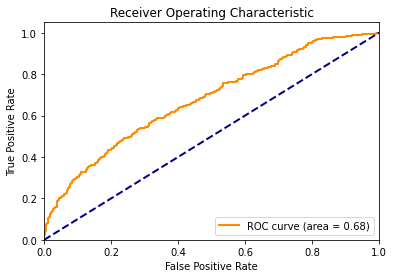

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6463 - loss: 0.6205
Validation Loss: 0.6289194822311401
Validation Accuracy: 0.6455696225166321
Test Loss: 0.6417089908233828
Inference Time (seconds): 3.3083903789520264
Test Accuracy: 0.6118081180811809
Confusion Matrix:
 [[414 292]
 [234 415]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61       706
           1       0.59      0.64      0.61       649

    accuracy                           0.61      1355
   macro avg       0.61      0.61      0.61      1355
weighted avg       0.61      0.61      0.61      1355

ROC AUC Score: 0.6765933207331393
Metrics saved successfully


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.6451 - loss: 0.6239 - val_accuracy: 0.6250 - val_loss: 0.6308
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.6429 - loss: 0.6236 - val_accuracy: 0.6013 - val_loss: 0.6347
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.6231 - loss: 0.6289 - val_accuracy: 0.6392 - val_loss: 0.6293
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.6495 - loss: 0.6161 - val_accuracy: 0.6313 - val_loss: 0.6233
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.6604 - loss: 0.6134 - val_accuracy: 0.6408 - val_loss: 0.6225
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.6565 - loss: 0.6178 - val_accuracy: 0.6013 - val_loss: 0.6330
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.6276 - loss: 0.6148 - val_accuracy: 0.6519 - val_loss: 0.6100
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.6609 - loss: 0.6051 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


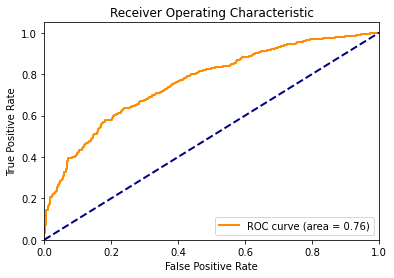

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7161 - loss: 0.5359
Validation Loss: 0.5457158088684082
Validation Accuracy: 0.7041139006614685
Test Loss: 0.5822689416435886
Inference Time (seconds): 3.238048553466797
Test Accuracy: 0.6856088560885609
Confusion Matrix:
 [[486 220]
 [206 443]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       706
           1       0.67      0.68      0.68       649

    accuracy                           0.69      1355
   macro avg       0.69      0.69      0.69      1355
weighted avg       0.69      0.69      0.69      1355

ROC AUC Score: 0.7616730031384086
Metrics saved successfully


In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [37]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.7330 - loss: 0.5192 - val_accuracy: 0.6788 - val_loss: 0.5604
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.7368 - loss: 0.5215 - val_accuracy: 0.6978 - val_loss: 0.5525
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.7386 - loss: 0.5124 - val_accuracy: 0.6883 - val_loss: 0.5490
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.7305 - loss: 0.5316 - val_accuracy: 0.7168 - val_loss: 0.5549
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7230 - loss: 0.5233 - val_accuracy: 0.7089 - val_loss: 0.5451
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.7444 - loss: 0.5102 - val_accuracy: 0.7104 - val_loss: 0.5347
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.7211 - loss: 0.5198 - val_accuracy: 0.7184 - val_loss: 0.5621
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7344 - loss: 0.5201 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


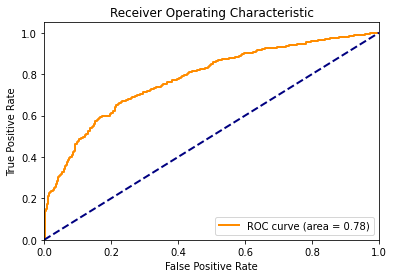

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7265 - loss: 0.5287
Validation Loss: 0.5346850752830505
Validation Accuracy: 0.7104430198669434
Test Loss: 0.5726328740961134
Inference Time (seconds): 3.2273013591766357
Test Accuracy: 0.7166051660516605
Confusion Matrix:
 [[584 122]
 [262 387]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.75       706
           1       0.76      0.60      0.67       649

    accuracy                           0.72      1355
   macro avg       0.73      0.71      0.71      1355
weighted avg       0.72      0.72      0.71      1355

ROC AUC Score: 0.7787923892499684
Metrics saved successfully


In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [39]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.7152 - loss: 0.5379 - val_accuracy: 0.6994 - val_loss: 0.5511
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7362 - loss: 0.5188 - val_accuracy: 0.7025 - val_loss: 0.5619
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7389 - loss: 0.5250 - val_accuracy: 0.6978 - val_loss: 0.5507
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7464 - loss: 0.4924 - val_accuracy: 0.7263 - val_loss: 0.5354
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7303 - loss: 0.5033 - val_accuracy: 0.6503 - val_loss: 0.5959
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.7225 - loss: 0.5244 - val_accuracy: 0.6978 - val_loss: 0.5621
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.7505 - loss: 0.5052 - val_accuracy: 0.6851 - val_loss: 0.5549
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.7640 - loss: 0.4894 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


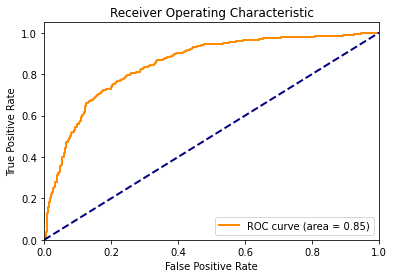

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7762 - loss: 0.4533
Validation Loss: 0.4752013087272644
Validation Accuracy: 0.7721518874168396
Test Loss: 0.5179233392527148
Inference Time (seconds): 3.2336127758026123
Test Accuracy: 0.7697416974169742
Confusion Matrix:
 [[519 187]
 [125 524]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77       706
           1       0.74      0.81      0.77       649

    accuracy                           0.77      1355
   macro avg       0.77      0.77      0.77      1355
weighted avg       0.77      0.77      0.77      1355

ROC AUC Score: 0.8488544153786388
Metrics saved successfully


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Conv2D+GlobalAveragePooling+Dropout+Dense

In [41]:
# Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 852ms/step - accuracy: 0.5057 - loss: 0.6951 - val_accuracy: 0.4984 - val_loss: 0.6938
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 842ms/step - accuracy: 0.4945 - loss: 0.6941 - val_accuracy: 0.4984 - val_loss: 0.6935
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 845ms/step - accuracy: 0.4956 - loss: 0.6935 - val_accuracy: 0.4984 - val_loss: 0.6930
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 845ms/step - accuracy: 0.5328 - loss: 0.6902 - val_accuracy: 0.5459 - val_loss: 0.6898
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 853ms/step - accuracy: 0.5212 - loss: 0.6924 - val_accuracy: 0.5301 - val_loss: 0.6881
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 849ms/step - accuracy: 0.5217 - loss: 0.6929 - val_accuracy: 0.5285 - val_loss: 0.6874
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 841ms/step - accuracy: 0.5415 - loss: 0.6922 - val_accuracy: 0.5459 - val_loss: 0.6875
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 848ms/step - accuracy: 0.5617 - loss: 0.6880 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step


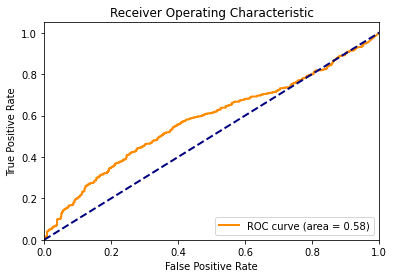

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.6187 - loss: 0.6705
Validation Loss: 0.6776235103607178
Validation Accuracy: 0.5838607549667358
Test Loss: 0.6766730418491631
Inference Time (seconds): 7.924245357513428
Test Accuracy: 0.5867158671586716
Confusion Matrix:
 [[532 174]
 [386 263]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.66       706
           1       0.60      0.41      0.48       649

    accuracy                           0.59      1355
   macro avg       0.59      0.58      0.57      1355
weighted avg       0.59      0.59      0.57      1355

ROC AUC Score: 0.5786315403519033
Metrics saved successfully


In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 849ms/step - accuracy: 0.5737 - loss: 0.6799 - val_accuracy: 0.5918 - val_loss: 0.6766
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 847ms/step - accuracy: 0.5725 - loss: 0.6793 - val_accuracy: 0.5823 - val_loss: 0.6757
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 846ms/step - accuracy: 0.5763 - loss: 0.6728 - val_accuracy: 0.5949 - val_loss: 0.6756
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 854ms/step - accuracy: 0.5660 - loss: 0.6767 - val_accuracy: 0.5918 - val_loss: 0.6741
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 846ms/step - accuracy: 0.5793 - loss: 0.6765 - val_accuracy: 0.5965 - val_loss: 0.6745
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 854ms/step - accuracy: 0.5819 - loss: 0.6750 - val_accuracy: 0.5854 - val_loss: 0.6754
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 845ms/step - accuracy: 0.5830 - loss: 0.6667 - val_accuracy: 0.6028 - val_loss: 0.6726
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 837ms/step - accuracy: 0.5765 - loss: 0.6715 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step


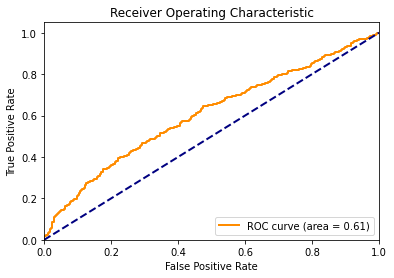

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6156 - loss: 0.6599
Validation Loss: 0.6671015620231628
Validation Accuracy: 0.5901898741722107
Test Loss: 0.6754728323127382
Inference Time (seconds): 7.896194219589233
Test Accuracy: 0.5712177121771218
Confusion Matrix:
 [[398 308]
 [273 376]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.56      0.58       706
           1       0.55      0.58      0.56       649

    accuracy                           0.57      1355
   macro avg       0.57      0.57      0.57      1355
weighted avg       0.57      0.57      0.57      1355

ROC AUC Score: 0.6060402362318145
Metrics saved successfully


In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [46]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 843ms/step - accuracy: 0.5857 - loss: 0.6683 - val_accuracy: 0.5997 - val_loss: 0.6707
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 848ms/step - accuracy: 0.5789 - loss: 0.6652 - val_accuracy: 0.5744 - val_loss: 0.6803
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 850ms/step - accuracy: 0.5926 - loss: 0.6672 - val_accuracy: 0.5965 - val_loss: 0.6725
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 845ms/step - accuracy: 0.5737 - loss: 0.6718 - val_accuracy: 0.5997 - val_loss: 0.6672
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 844ms/step - accuracy: 0.5808 - loss: 0.6701 - val_accuracy: 0.5759 - val_loss: 0.6714
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 844ms/step - accuracy: 0.6025 - loss: 0.6589 - val_accuracy: 0.6044 - val_loss: 0.6651
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 846ms/step - accuracy: 0.5849 - loss: 0.6750 - val_accuracy: 0.5839 - val_loss: 0.6644
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 848ms/step - accuracy: 0.5961 - loss: 0.6535 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step


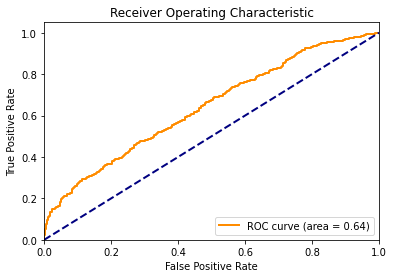

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.6192 - loss: 0.6364
Validation Loss: 0.6448055505752563
Validation Accuracy: 0.6123417615890503
Test Loss: 0.6579886050048521
Inference Time (seconds): 7.910983562469482
Test Accuracy: 0.592619926199262
Confusion Matrix:
 [[488 218]
 [334 315]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       706
           1       0.59      0.49      0.53       649

    accuracy                           0.59      1355
   macro avg       0.59      0.59      0.59      1355
weighted avg       0.59      0.59      0.59      1355

ROC AUC Score: 0.6407416945660573
Metrics saved successfully


In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 841ms/step - accuracy: 0.6258 - loss: 0.6459 - val_accuracy: 0.6187 - val_loss: 0.6439
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 847ms/step - accuracy: 0.6189 - loss: 0.6496 - val_accuracy: 0.6139 - val_loss: 0.6456
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 844ms/step - accuracy: 0.6281 - loss: 0.6408 - val_accuracy: 0.6155 - val_loss: 0.6508
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 849ms/step - accuracy: 0.6102 - loss: 0.6505 - val_accuracy: 0.6171 - val_loss: 0.6514
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 850ms/step - accuracy: 0.6047 - loss: 0.6525 - val_accuracy: 0.6218 - val_loss: 0.6429
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 847ms/step - accuracy: 0.6173 - loss: 0.6378 - val_accuracy: 0.6171 - val_loss: 0.6409
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 843ms/step - accuracy: 0.6384 - loss: 0.6421 - val_accuracy: 0.6171 - val_loss: 0.6489
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 849ms/step - accuracy: 0.6267 - loss: 0.6469 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step


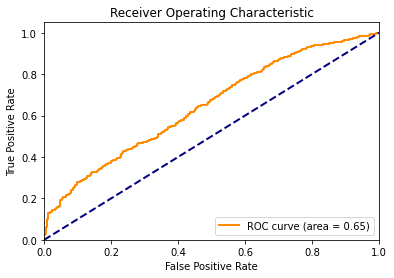

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6288 - loss: 0.6308
Validation Loss: 0.6409169435501099
Validation Accuracy: 0.6170886158943176
Test Loss: 0.654637140374979
Inference Time (seconds): 7.8604700565338135
Test Accuracy: 0.5985239852398524
Confusion Matrix:
 [[525 181]
 [363 286]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66       706
           1       0.61      0.44      0.51       649

    accuracy                           0.60      1355
   macro avg       0.60      0.59      0.59      1355
weighted avg       0.60      0.60      0.59      1355

ROC AUC Score: 0.6459469133161936
Metrics saved successfully


In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+LSTM+Dense

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (224, 224, 3)

# Define the CNN base model
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Define the LSTM layer
reshape = Reshape((1, -1))(flatten)
lstm = LSTM(128)(reshape)

# Define the dense layers for classification
dense1 = Dense(64, activation='relu')(lstm)
output_layer = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 186624)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    95,617,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,645,249 (364.86 MB)

 Trainable params: 95,645,249 (364.86 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 742ms/step - accuracy: 0.4947 - loss: 0.7146 - val_accuracy: 0.4984 - val_loss: 0.6959
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5111 - loss: 0.6943 - val_accuracy: 0.4984 - val_loss: 0.6971
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.4887 - loss: 0.6943 - val_accuracy: 0.4984 - val_loss: 0.6997
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 731ms/step - accuracy: 0.5251 - loss: 0.6926 - val_accuracy: 0.5190 - val_loss: 0.6920
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.4887 - loss: 0.6946 - val_accuracy: 0.4984 - val_loss: 0.6934
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.4830 - loss: 0.6955 - val_accuracy: 0.5016 - val_loss: 0.6945
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 731ms/step - accuracy: 0.4967 - loss: 0.6961 - val_accuracy: 0.4984 - val_loss: 0.6912
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.4845 - loss: 0.6950 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


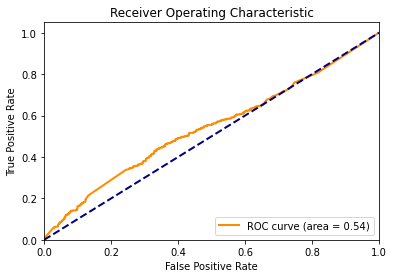

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4835 - loss: 0.6899
Validation Loss: 0.6911553144454956
Validation Accuracy: 0.4984177350997925
Test Loss: 0.6925112053072695
Inference Time (seconds): 3.5138914585113525
Test Accuracy: 0.4789667896678967
Confusion Matrix:
 [[  0 706]
 [  0 649]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       706
           1       0.48      1.00      0.65       649

    accuracy                           0.48      1355
   macro avg       0.24      0.50      0.32      1355
weighted avg       0.23      0.48      0.31      1355

ROC AUC Score: 0.5407120128155323
Metrics saved successfully


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 732ms/step - accuracy: 0.5101 - loss: 0.6939 - val_accuracy: 0.4984 - val_loss: 0.7049
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5174 - loss: 0.6947 - val_accuracy: 0.5411 - val_loss: 0.6915
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.5103 - loss: 0.6929 - val_accuracy: 0.5016 - val_loss: 0.6939
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5091 - loss: 0.6946 - val_accuracy: 0.4984 - val_loss: 0.6934
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 731ms/step - accuracy: 0.4873 - loss: 0.6937 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5222 - loss: 0.6933 - val_accuracy: 0.4984 - val_loss: 0.6946
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5105 - loss: 0.6934 - val_accuracy: 0.4984 - val_loss: 0.6936
Training Time: 404.5466094017029 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


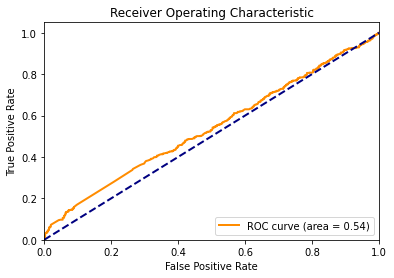

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5668 - loss: 0.6899
Validation Loss: 0.6915173530578613
Validation Accuracy: 0.5411392450332642
Test Loss: 0.6904575546851052
Inference Time (seconds): 3.367072105407715
Test Accuracy: 0.5505535055350553
Confusion Matrix:
 [[660  46]
 [563  86]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.93      0.68       706
           1       0.65      0.13      0.22       649

    accuracy                           0.55      1355
   macro avg       0.60      0.53      0.45      1355
weighted avg       0.59      0.55      0.46      1355

ROC AUC Score: 0.5393676041152875
Metrics saved successfully


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 732ms/step - accuracy: 0.4982 - loss: 0.6941 - val_accuracy: 0.5016 - val_loss: 0.6962
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 728ms/step - accuracy: 0.5077 - loss: 0.6955 - val_accuracy: 0.4984 - val_loss: 0.6964
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 731ms/step - accuracy: 0.4957 - loss: 0.6960 - val_accuracy: 0.5016 - val_loss: 0.6940
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.4982 - loss: 0.6944 - val_accuracy: 0.4984 - val_loss: 0.6981
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 732ms/step - accuracy: 0.5077 - loss: 0.6954 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5193 - loss: 0.6930 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5090 - loss: 0.6934 - val_accuracy: 0.4984 - val_loss: 0.6951
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.5002 - loss: 0.6945 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


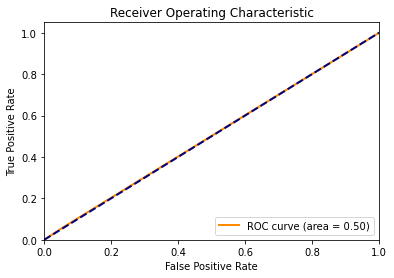

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5165 - loss: 0.6930
Validation Loss: 0.693139374256134
Validation Accuracy: 0.5015822649002075
Test Loss: 0.6929305925965641
Inference Time (seconds): 3.341874122619629
Test Accuracy: 0.5210332103321034
Confusion Matrix:
 [[706   0]
 [649   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.69       706
           1       0.00      0.00      0.00       649

    accuracy                           0.52      1355
   macro avg       0.26      0.50      0.34      1355
weighted avg       0.27      0.52      0.36      1355

ROC AUC Score: 0.5015364670859941
Metrics saved successfully


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 731ms/step - accuracy: 0.5162 - loss: 0.6940 - val_accuracy: 0.4984 - val_loss: 0.6982
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.5047 - loss: 0.6941 - val_accuracy: 0.4984 - val_loss: 0.6992
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 735ms/step - accuracy: 0.4996 - loss: 0.6975 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.5062 - loss: 0.6944 - val_accuracy: 0.4984 - val_loss: 0.6942
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 728ms/step - accuracy: 0.4861 - loss: 0.6939 - val_accuracy: 0.4984 - val_loss: 0.6946
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.5093 - loss: 0.6926 - val_accuracy: 0.5016 - val_loss: 0.6934
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.4769 - loss: 0.6951 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 730ms/step - accuracy: 0.4983 - loss: 0.6931 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


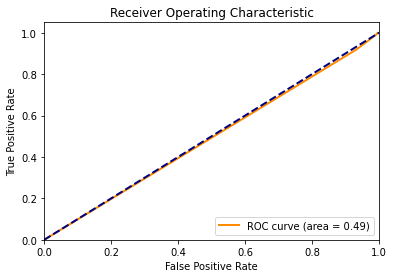

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5165 - loss: 0.6930
Validation Loss: 0.693138837814331
Validation Accuracy: 0.5015822649002075
Test Loss: 0.6930066543739499
Inference Time (seconds): 3.3752634525299072
Test Accuracy: 0.5210332103321034
Confusion Matrix:
 [[706   0]
 [649   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.69       706
           1       0.00      0.00      0.00       649

    accuracy                           0.52      1355
   macro avg       0.26      0.50      0.34      1355
weighted avg       0.27      0.52      0.36      1355

ROC AUC Score: 0.49320047839997905
Metrics saved successfully


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GRU+Dense

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, GRU, Dense
from tensorflow.keras.models import Sequential

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(256, (3, 3), activation='relu'),  # Convolutional layer with 256 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to flatten the output of the convolutional layers
    Reshape((1, -1)),  # Reshape to 3D tensor for GRU
    GRU(128),  # GRU layer with 128 units
    Dense(1, activation='sigmoid')  # Dense layer for binary classification
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 36864)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │    14,205,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,594,241 (55.67 MB)

 Trainable params: 14,594,241 (55.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step - accuracy: 0.5217 - loss: 0.7361 - val_accuracy: 0.5380 - val_loss: 0.6868
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.5259 - loss: 0.6855 - val_accuracy: 0.5759 - val_loss: 0.6804
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.5440 - loss: 0.6771 - val_accuracy: 0.5791 - val_loss: 0.6797
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.5650 - loss: 0.6761 - val_accuracy: 0.5696 - val_loss: 0.6738
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.5873 - loss: 0.6636 - val_accuracy: 0.5063 - val_loss: 0.6834
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.5903 - loss: 0.6623 - val_accuracy: 0.6266 - val_loss: 0.6549
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.6084 - loss: 0.6432 - val_accuracy: 0.5680 - val_loss: 0.6810
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.6245 - loss: 0.6369 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


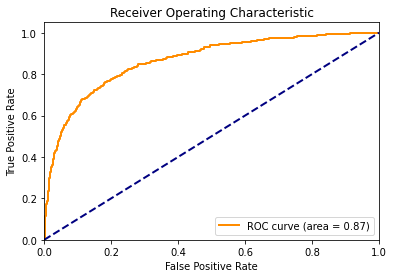

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7940 - loss: 0.4439
Validation Loss: 0.47493940591812134
Validation Accuracy: 0.7911392450332642
Test Loss: 0.5020480248396568
Inference Time (seconds): 4.028616666793823
Test Accuracy: 0.7800738007380074
Confusion Matrix:
 [[508 198]
 [100 549]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.77       706
           1       0.73      0.85      0.79       649

    accuracy                           0.78      1355
   macro avg       0.79      0.78      0.78      1355
weighted avg       0.79      0.78      0.78      1355

ROC AUC Score: 0.8654652832642942
Metrics saved successfully


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8588 - loss: 0.3014 - val_accuracy: 0.7959 - val_loss: 0.4782
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.8876 - loss: 0.2740 - val_accuracy: 0.7722 - val_loss: 0.5645
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.8912 - loss: 0.2554 - val_accuracy: 0.7927 - val_loss: 0.5107
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.9185 - loss: 0.1959 - val_accuracy: 0.8101 - val_loss: 0.5083
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9355 - loss: 0.1630 - val_accuracy: 0.7975 - val_loss: 0.5558
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.9434 - loss: 0.1336 - val_accuracy: 0.8180 - val_loss: 0.5614
Training Time: 166.56884765625 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


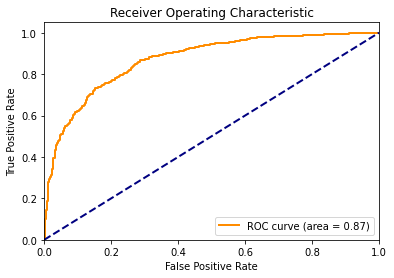

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8010 - loss: 0.4556
Validation Loss: 0.47819146513938904
Validation Accuracy: 0.7958860993385315
Test Loss: 0.5107779870924957
Inference Time (seconds): 3.8633172512054443
Test Accuracy: 0.7793357933579336
Confusion Matrix:
 [[524 182]
 [117 532]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       706
           1       0.75      0.82      0.78       649

    accuracy                           0.78      1355
   macro avg       0.78      0.78      0.78      1355
weighted avg       0.78      0.78      0.78      1355

ROC AUC Score: 0.870637764789587
Metrics saved successfully


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.8832 - loss: 0.2555 - val_accuracy: 0.8054 - val_loss: 0.4931
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9177 - loss: 0.2038 - val_accuracy: 0.7785 - val_loss: 0.5516
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9191 - loss: 0.2151 - val_accuracy: 0.8259 - val_loss: 0.5200
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.9381 - loss: 0.1456 - val_accuracy: 0.8022 - val_loss: 0.5158
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9406 - loss: 0.1365 - val_accuracy: 0.8133 - val_loss: 0.6000
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9515 - loss: 0.1107 - val_accuracy: 0.8196 - val_loss: 0.5520
Training Time: 166.833642244339 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


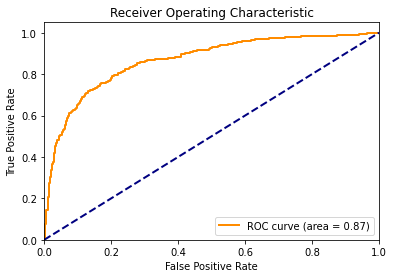

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8214 - loss: 0.4621
Validation Loss: 0.49306759238243103
Validation Accuracy: 0.8053797483444214
Test Loss: 0.5103149105230443
Inference Time (seconds): 3.8913753032684326
Test Accuracy: 0.7940959409594096
Confusion Matrix:
 [[589 117]
 [162 487]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       706
           1       0.81      0.75      0.78       649

    accuracy                           0.79      1355
   macro avg       0.80      0.79      0.79      1355
weighted avg       0.79      0.79      0.79      1355

ROC AUC Score: 0.8664124803031031
Metrics saved successfully


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 356ms/step - accuracy: 0.9127 - loss: 0.2180 - val_accuracy: 0.8133 - val_loss: 0.4969
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.9135 - loss: 0.1992 - val_accuracy: 0.8070 - val_loss: 0.4971
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.9461 - loss: 0.1601 - val_accuracy: 0.8165 - val_loss: 0.5353
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9485 - loss: 0.1342 - val_accuracy: 0.8180 - val_loss: 0.5728
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9699 - loss: 0.0836 - val_accuracy: 0.8196 - val_loss: 0.6194
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.9761 - loss: 0.0728 - val_accuracy: 0.8085 - val_loss: 0.6345
Training Time: 167.2816128730774 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


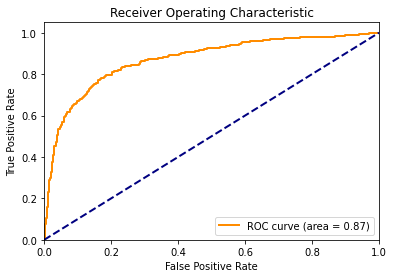

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8190 - loss: 0.4688
Validation Loss: 0.49694815278053284
Validation Accuracy: 0.8132911324501038
Test Loss: 0.5520541948165844
Inference Time (seconds): 3.866614580154419
Test Accuracy: 0.8029520295202952
Confusion Matrix:
 [[562 144]
 [123 526]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       706
           1       0.79      0.81      0.80       649

    accuracy                           0.80      1355
   macro avg       0.80      0.80      0.80      1355
weighted avg       0.80      0.80      0.80      1355

ROC AUC Score: 0.8701379764903077
Metrics saved successfully


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Attention Mechanism+Dense

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply
from tensorflow.keras.models import Model

# Define the custom CNN architecture with attention mechanism
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
attention_probs = Dense(np.prod(x.shape[1:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
x = Dense(1, activation='sigmoid')(attention_mul)

# Create the model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 111, 111,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 54, 54,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 26, 26,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 86528)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │ 22,151,424 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    131,584 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_probs     │ (None, 512)       │    262,656 │ dense_6[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 512)       │          0 │ dense_6[0][0],    │
│                     │                   │            │ attention_probs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        513 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,639,425 (86.36 MB)

 Trainable params: 22,639,425 (86.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 344ms/step - accuracy: 0.5073 - loss: 0.6934 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 345ms/step - accuracy: 0.5225 - loss: 0.6928 - val_accuracy: 0.4984 - val_loss: 0.6930
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5114 - loss: 0.6915 - val_accuracy: 0.4984 - val_loss: 0.6914
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5137 - loss: 0.6867 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5153 - loss: 0.6930 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - accuracy: 0.5189 - loss: 0.6928 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


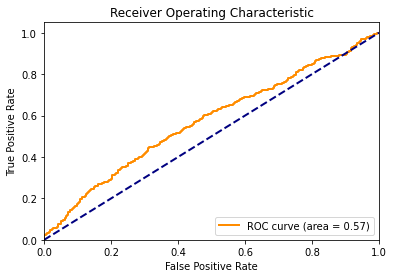

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4835 - loss: 0.6907
Validation Loss: 0.6913951635360718
Validation Accuracy: 0.4984177350997925
Test Loss: 0.6933664691179668
Inference Time (seconds): 3.473698139190674
Test Accuracy: 0.4789667896678967
Confusion Matrix:
 [[  0 706]
 [  0 649]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       706
           1       0.48      1.00      0.65       649

    accuracy                           0.48      1355
   macro avg       0.24      0.50      0.32      1355
weighted avg       0.23      0.48      0.31      1355

ROC AUC Score: 0.5738944639170307
Metrics saved successfully


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.5245 - loss: 0.6863 - val_accuracy: 0.4984 - val_loss: 0.6878
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5204 - loss: 0.6834 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - accuracy: 0.5035 - loss: 0.6931 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5193 - loss: 0.6929 - val_accuracy: 0.4984 - val_loss: 0.6933
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.5071 - loss: 0.6931 - val_accuracy: 0.4984 - val_loss: 0.6933
Training Time: 162.841299533844 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


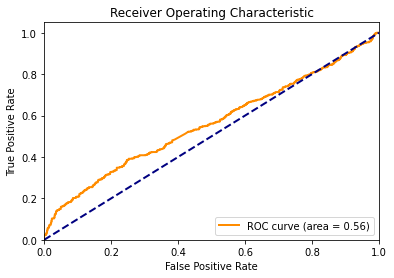

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4835 - loss: 0.6904
Validation Loss: 0.6877738833427429
Validation Accuracy: 0.4984177350997925
Test Loss: 0.6845737756933699
Inference Time (seconds): 3.3921163082122803
Test Accuracy: 0.4797047970479705
Confusion Matrix:
 [[  1 705]
 [  0 649]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       706
           1       0.48      1.00      0.65       649

    accuracy                           0.48      1355
   macro avg       0.74      0.50      0.33      1355
weighted avg       0.75      0.48      0.31      1355

ROC AUC Score: 0.5598938440922404
Metrics saved successfully


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - accuracy: 0.5126 - loss: 0.6832 - val_accuracy: 0.5538 - val_loss: 0.6863
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5544 - loss: 0.6821 - val_accuracy: 0.5237 - val_loss: 0.6852
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5105 - loss: 0.6878 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.4906 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5266 - loss: 0.6930 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.4984 - val_loss: 0.6933
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - accuracy: 0.5276 - loss: 0.6926 - val_accuracy: 0.4984 - val_loss: 0.6933
Training Time: 189.75763630867004 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


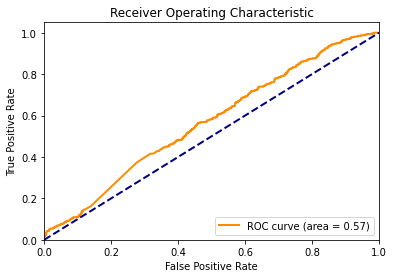

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5292 - loss: 0.6875
Validation Loss: 0.6852086782455444
Validation Accuracy: 0.5237341523170471
Test Loss: 0.6857837629270471
Inference Time (seconds): 3.4329171180725098
Test Accuracy: 0.5328413284132841
Confusion Matrix:
 [[684  22]
 [611  38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.97      0.68       706
           1       0.63      0.06      0.11       649

    accuracy                           0.53      1355
   macro avg       0.58      0.51      0.40      1355
weighted avg       0.58      0.53      0.41      1355

ROC AUC Score: 0.5683498692693487
Metrics saved successfully


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.5194 - loss: 0.6820 - val_accuracy: 0.5269 - val_loss: 0.6804
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5334 - loss: 0.6794 - val_accuracy: 0.5301 - val_loss: 0.6861
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.5526 - loss: 0.6827 - val_accuracy: 0.5617 - val_loss: 0.6709
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.5810 - loss: 0.6653 - val_accuracy: 0.5728 - val_loss: 0.6674
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - accuracy: 0.5870 - loss: 0.6685 - val_accuracy: 0.6092 - val_loss: 0.6709
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.6171 - loss: 0.6566 - val_accuracy: 0.5934 - val_loss: 0.6750
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.6030 - loss: 0.6666 - val_accuracy: 0.5949 - val_loss: 0.6559
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step - accuracy: 0.6098 - loss: 0.6428 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


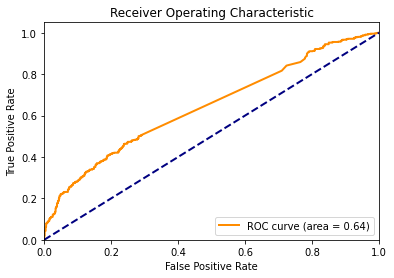

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6370 - loss: 0.6420
Validation Loss: 0.6466063261032104
Validation Accuracy: 0.6186708807945251
Test Loss: 0.6581757080402173
Inference Time (seconds): 3.4177143573760986
Test Accuracy: 0.6088560885608856
Confusion Matrix:
 [[549 157]
 [373 276]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.78      0.67       706
           1       0.64      0.43      0.51       649

    accuracy                           0.61      1355
   macro avg       0.62      0.60      0.59      1355
weighted avg       0.62      0.61      0.60      1355

ROC AUC Score: 0.6430496689175328
Metrics saved successfully


In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Capsule Network+Dense

In [33]:
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Reshape, Dense
from tensorflow.keras.models import Model

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j

# Define your custom CNN architecture
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((-1, 128))(x)  # Reshape to 3D tensor for Capsule Network
capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
capsule = Flatten()(capsule)  # Flatten the output
output = Dense(1, activation='sigmoid')(capsule)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 160)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,601 (42.68 MB)

 Trainable params: 11,189,601 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 296ms/step - accuracy: 0.5084 - loss: 0.6964 - val_accuracy: 0.4984 - val_loss: 0.6945
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.5016 - val_loss: 0.6930
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.4915 - loss: 0.6938 - val_accuracy: 0.5680 - val_loss: 0.6860
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.5473 - loss: 0.6875 - val_accuracy: 0.5063 - val_loss: 0.6830
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.5568 - loss: 0.6852 - val_accuracy: 0.5839 - val_loss: 0.6675
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.5689 - loss: 0.6712 - val_accuracy: 0.5902 - val_loss: 0.6531
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.5994 - loss: 0.6572 - val_accuracy: 0.6741 - val_loss: 0.6126
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.6620 - loss: 0.6188 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


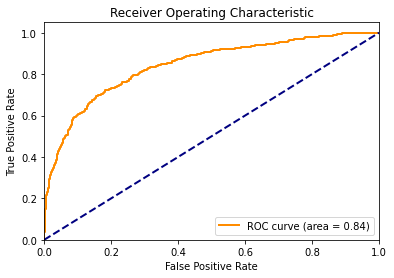

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7766 - loss: 0.4601
Validation Loss: 0.4674415588378906
Validation Accuracy: 0.7721518874168396
Test Loss: 0.49678761818092887
Inference Time (seconds): 3.4749932289123535
Test Accuracy: 0.7682656826568266
Confusion Matrix:
 [[584 122]
 [192 457]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       706
           1       0.79      0.70      0.74       649

    accuracy                           0.77      1355
   macro avg       0.77      0.77      0.77      1355
weighted avg       0.77      0.77      0.77      1355

ROC AUC Score: 0.8426212477684124
Metrics saved successfully


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [36]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.8102 - loss: 0.3998 - val_accuracy: 0.7547 - val_loss: 0.5194
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8246 - loss: 0.3882 - val_accuracy: 0.7658 - val_loss: 0.4769
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8441 - loss: 0.3462 - val_accuracy: 0.7389 - val_loss: 0.5134
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8488 - loss: 0.3496 - val_accuracy: 0.7722 - val_loss: 0.4629
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8699 - loss: 0.3100 - val_accuracy: 0.7690 - val_loss: 0.4898
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8484 - loss: 0.3368 - val_accuracy: 0.7816 - val_loss: 0.4663
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.8843 - loss: 0.2758 - val_accuracy: 0.7690 - val_loss: 0.5260
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8882 - loss: 0.2728 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


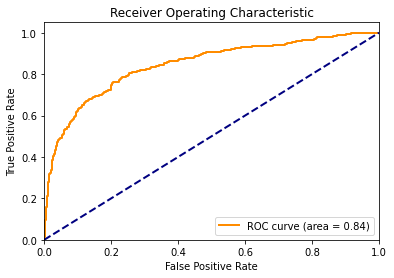

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7569 - loss: 0.4657
Validation Loss: 0.46287164092063904
Validation Accuracy: 0.7721518874168396
Test Loss: 0.4941753947418507
Inference Time (seconds): 3.367704391479492
Test Accuracy: 0.7741697416974169
Confusion Matrix:
 [[565 141]
 [165 484]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79       706
           1       0.77      0.75      0.76       649

    accuracy                           0.77      1355
   macro avg       0.77      0.77      0.77      1355
weighted avg       0.77      0.77      0.77      1355

ROC AUC Score: 0.8444632622862804
Metrics saved successfully


In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [38]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.8546 - loss: 0.3248 - val_accuracy: 0.7848 - val_loss: 0.4660
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8601 - loss: 0.3157 - val_accuracy: 0.7848 - val_loss: 0.4999
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8745 - loss: 0.3007 - val_accuracy: 0.7832 - val_loss: 0.4739
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8720 - loss: 0.2854 - val_accuracy: 0.7911 - val_loss: 0.4884
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.9059 - loss: 0.2382 - val_accuracy: 0.7880 - val_loss: 0.5012
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9152 - loss: 0.2078 - val_accuracy: 0.7722 - val_loss: 0.5253
Training Time: 138.19280529022217 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


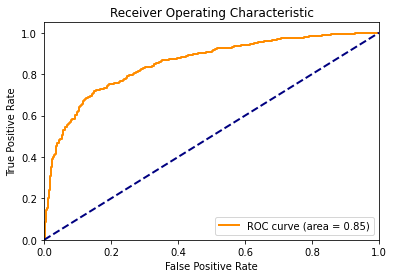

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7742 - loss: 0.4696
Validation Loss: 0.46603670716285706
Validation Accuracy: 0.7848101258277893
Test Loss: 0.4947290743422012
Inference Time (seconds): 3.3738529682159424
Test Accuracy: 0.777859778597786
Confusion Matrix:
 [[577 129]
 [172 477]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79       706
           1       0.79      0.73      0.76       649

    accuracy                           0.78      1355
   macro avg       0.78      0.78      0.78      1355
weighted avg       0.78      0.78      0.78      1355

ROC AUC Score: 0.8531342619065287
Metrics saved successfully


In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [40]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.8820 - loss: 0.2886 - val_accuracy: 0.7627 - val_loss: 0.4965
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8793 - loss: 0.2910 - val_accuracy: 0.7690 - val_loss: 0.4999
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.8860 - loss: 0.2726 - val_accuracy: 0.7642 - val_loss: 0.5029
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.8952 - loss: 0.2555 - val_accuracy: 0.8006 - val_loss: 0.4674
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.8942 - loss: 0.2466 - val_accuracy: 0.7595 - val_loss: 0.5196
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9048 - loss: 0.2290 - val_accuracy: 0.7595 - val_loss: 0.5551
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.9176 - loss: 0.1991 - val_accuracy: 0.7911 - val_loss: 0.5405
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9191 - loss: 0.1977 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


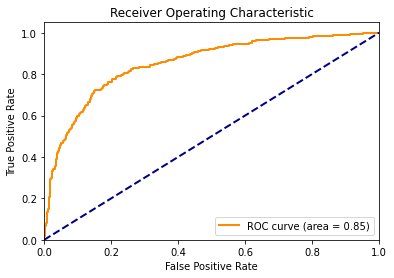

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8029 - loss: 0.4620
Validation Loss: 0.46739912033081055
Validation Accuracy: 0.800632894039154
Test Loss: 0.537846560795913
Inference Time (seconds): 3.3617491722106934
Test Accuracy: 0.7808118081180812
Confusion Matrix:
 [[534 172]
 [125 524]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       706
           1       0.75      0.81      0.78       649

    accuracy                           0.78      1355
   macro avg       0.78      0.78      0.78      1355
weighted avg       0.78      0.78      0.78      1355

ROC AUC Score: 0.8519360794772519
Metrics saved successfully


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")